# Excercise 1.1

In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')


stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt") as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

# create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()

# compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

# computing the search result
def search_vec(query, topk=10):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    for i in range(topk):
        doc_ids.append(scores[i][1])
    return doc_ids
# HINTS

# natural logarithm function
#     math.log(n,math.e)
# Function to count term frequencies in a document
#     Counter(document)
# most common elements for a list
#     counts.most_common(1)

[nltk_data] Downloading package stopwords to /Users/duong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tf_doc_ids = search_vec('computer science')
for i, v in enumerate(tf_doc_ids):
    print(original_documents[v])

Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
New at @epfl_en Life Sciences @epflSV: "From PhD directly to Independent Group Leader" #ELFIR_EPFL:  Early Independence Research Scholars. See https://t.co/evqyqD7FFl, also for computational biology #compbio https://t.co/e3pDCg6NVb Deadline April 1 2018 at https://t.co/mJqcrfIqkb
Video of Nicola Marzari from @EPFL_en  on Computational Discovery in the 21st Century during #PASC17 now online: https://t.co/tfCkEvYKtq https://t.co/httPdHcK9W
Exposure Science Film Hackathon 2017 applications open! Come join our Scicomm-film-hacking event! #Science #scicomm https://t.co/zwtKPlh6HT


# Exercise 1.2

In [3]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [4]:
ret_ids = search_vec_sklearn('computer science', features)
for i, v in enumerate(ret_ids):
    print(original_documents[v])

Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
Exposure Science Film Hackathon 2017 applications open! Come join our Scicomm-film-hacking event! #Science #scicomm https://t.co/zwtKPlh6HT
Le mystère Soulages éblouit la science @EPFL  https://t.co/u3uNICyAdi
@cwarwarrior @EPFL_en @EPFL Doing science at @EPFL_en is indeed pretty cool!!! Thank you for visiting!!!
Blue Brain Nexus: an open-source tool for data-driven science https://t.co/m5yTgXf7ym #epfl
Swiss Data Science on Twitter: "Sign up for @EPFL_en #DataJamDays: learn more a… https://t.co/kNVILHWPGb, see more https://t.co/2wg3BbHBNq
The registration for Exposure Scienc

In [5]:
queries = ["computer science", "IC school", "information systems"]

## Exercise 2.1

In [6]:
def compute_recall_at_k(predict, gt, k):
    correct_recall = set(predict[:k]).intersection(set(gt))
    return len(correct_recall)/len(gt)

In [7]:
def compute_precision_at_k(predict, gt, k):
    correct_predict = set(predict[:k]).intersection(set(gt))
    return len(correct_predict)/k

## Exercise 2.2

In [8]:
def compute_interpolated_precisions(prec_rec):
    max_prec = []
    current_rec = prec_rec[-1][1]
    for k, (prec, rec) in enumerate(prec_rec):
        max_p = prec
        for j, (p, r) in enumerate(prec_rec[k+1:]):
            if p > max_p and r >= rec:
                max_p = p
        max_prec.append(max_p)
    return max_prec

In [9]:
def compute_map(queries):
    map_score = 0
    prec_rec_dict = []
    for i, query in enumerate(queries):
        predict = search_vec(query, 10)
        gt = search_vec_sklearn(query, features)
        prec_rec = []
        for k in range(1, len(gt)+1):
            precision_at_k = compute_precision_at_k(predict, gt, k)
            recall_at_k = compute_recall_at_k(predict, gt, k)
            prec_rec.append((precision_at_k, recall_at_k))
        precs_int = compute_interpolated_precisions(prec_rec)
        map_score += sum(precs_int)/len(gt)
        prec_rec_dict.append(prec_rec)
    map_score = map_score/len(queries)
    return map_score, prec_rec_dict

In [10]:
map_score, prec_rec_dict = compute_map(queries)

In [11]:
map_score

0.5874681113152389

In [12]:
import matplotlib
import matplotlib.pyplot as plt

prec = [1.0, 0.5, 2/3, 2/4, 3/5, 4/6, 4/7, 4/8, 5/9, 6/10, 7/11 , 7/12, 8/13, 8/14  ]
rec = [1/100, 1/100, 2/100, 2/100, 3/100, 4/100, 4/100, 4/100, 5/100, 6/100, 7/100, 7/100, 8/100, 8/100]
def draw_scatter(prec, rec, prec_int=None):
    fig, ax = plt.subplots()
    ax.xaxis.grid(True)    
    ax.plot(rec,prec,zorder=2) 
#     ax.scatter(rec,prec,zorder=1,c=relevant,cmap=plt.cm.RdYlGn,s=100)
    ax.scatter(rec,prec,zorder=1,s=100)
    if prec_int==None:
        prec_int = compute_interpolated_precisions(list(zip(prec, rec)))
    ax.plot(rec, prec_int, zorder=2)
    ax.scatter(rec,prec_int,zorder=1,s=100)
    ax.set(xlabel='Recall', ylabel='Precision',
           title='Prec-Recall')
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim([0.1,1.1])
    fig.savefig("prec_rec.png")

    plt.show()

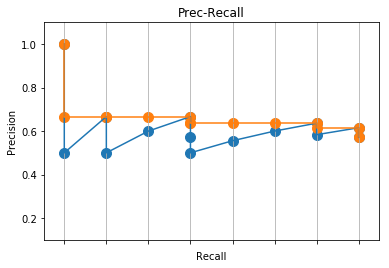

In [13]:
draw_scatter(prec, rec)